In [71]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np


In [16]:
! pip install -q kaggle

In [17]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"margolevin","key":"1a0350ee76e573aa1c2297a1afd2b4d8"}'}

In [18]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [19]:
! cp kaggle.json ~/.kaggle/



In [20]:
! chmod 600 ~/.kaggle/kaggle.json

In [21]:
!kaggle datasets download -d sabari50312/fundus-pytorch

... resuming from 1756364800 bytes (2341149170 bytes left) ...
100% 3.82G/3.82G [01:00<00:00, 42.1MB/s]
100% 3.82G/3.82G [01:00<00:00, 38.8MB/s]


In [22]:
! mkdir train



mkdir: cannot create directory ‘train’: File exists


In [23]:
! unzip fundus-pytorch.zip -d train



Streaming output truncated to the last 5000 lines.
  inflating: train/val/0/OIA-ODIR-TEST-OFFLINE-16.png  
  inflating: train/val/0/OIA-ODIR-TEST-OFFLINE-160.png  
  inflating: train/val/0/OIA-ODIR-TEST-OFFLINE-163.png  
  inflating: train/val/0/OIA-ODIR-TEST-OFFLINE-164.png  
  inflating: train/val/0/OIA-ODIR-TEST-OFFLINE-165.png  
  inflating: train/val/0/OIA-ODIR-TEST-OFFLINE-168.png  
  inflating: train/val/0/OIA-ODIR-TEST-OFFLINE-17.png  
  inflating: train/val/0/OIA-ODIR-TEST-OFFLINE-170.png  
  inflating: train/val/0/OIA-ODIR-TEST-OFFLINE-173.png  
  inflating: train/val/0/OIA-ODIR-TEST-OFFLINE-175.png  
  inflating: train/val/0/OIA-ODIR-TEST-OFFLINE-177.png  
  inflating: train/val/0/OIA-ODIR-TEST-OFFLINE-179.png  
  inflating: train/val/0/OIA-ODIR-TEST-OFFLINE-18.png  
  inflating: train/val/0/OIA-ODIR-TEST-OFFLINE-180.png  
  inflating: train/val/0/OIA-ODIR-TEST-OFFLINE-181.png  
  inflating: train/val/0/OIA-ODIR-TEST-OFFLINE-182.png  
  inflating: train/val/0/OIA-ODIR-TEST-O

In [73]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [25]:
data_root = '/content/train'

# Create a list of datasets for both classes (0 and 1)
train_dataset = ImageFolder(os.path.join(data_root, 'train'), transform=transform)
val_dataset = ImageFolder(os.path.join(data_root, 'val'), transform=transform)
test_dataset = ImageFolder(os.path.join(data_root, 'test'), transform=transform)


In [48]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [32]:
class GlaucomaModel(nn.Module):
    def __init__(self):
        super(GlaucomaModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, 2)  # 2 output classes (0 or 1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 128 * 56 * 56)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [63]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),  # Experiment with the number of neurons in the fully connected layer
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  # 2 output classes (0 or 1)
)

# Send the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Use AdamW optimizer with weight decay

# Learning rate scheduler (Cosine Annealing)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs * len(train_loader))

# Training loop

In [64]:
num_epochs = 30  # Experiment with the number of epochs

best_val_accuracy = 0.0  # Initialize best validation accuracy

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Print training loss for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # Adjust learning rate using the scheduler
    scheduler.step()

    # Evaluation on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = (100 * correct / total)
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Save the model if it has the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/30, Loss: 0.3766429960727692
Validation Accuracy: 88.55%
Epoch 2/30, Loss: 0.2956963092088699
Validation Accuracy: 89.46%
Epoch 3/30, Loss: 0.2628158199014487
Validation Accuracy: 89.73%
Epoch 4/30, Loss: 0.24551549001976294
Validation Accuracy: 91.70%
Epoch 5/30, Loss: 0.2328894798954328
Validation Accuracy: 90.71%
Epoch 6/30, Loss: 0.21593511408125912
Validation Accuracy: 92.52%
Epoch 7/30, Loss: 0.2035040451972573
Validation Accuracy: 92.29%
Epoch 8/30, Loss: 0.19825177915670253
Validation Accuracy: 93.25%
Epoch 9/30, Loss: 0.18716623545796782
Validation Accuracy: 93.30%
Epoch 10/30, Loss: 0.17281908448095676
Validation Accuracy: 92.67%
Epoch 11/30, Loss: 0.17223470895378679
Validation Accuracy: 94.22%
Epoch 12/30, Loss: 0.1654212145341767
Validation Accuracy: 94.94%
Epoch 13/30, Loss: 0.1500287644289158
Validation Accuracy: 94.64%
Epoch 14/30, Loss: 0.13937820256860167
Validation Accuracy: 94.69%
Epoch 15/30, Loss: 0.13609957477008855
Validation Accuracy: 95.08%
Epoch 16/30

In [65]:
model.load_state_dict(torch.load('best_model.pth'))

# Evaluation on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {(100 * correct / total):.2f}%")

Test Accuracy: 98.54%


Test Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1754
           1       0.98      0.98      0.98      1120

    accuracy                           0.98      2874
   macro avg       0.98      0.98      0.98      2874
weighted avg       0.98      0.98      0.98      2874



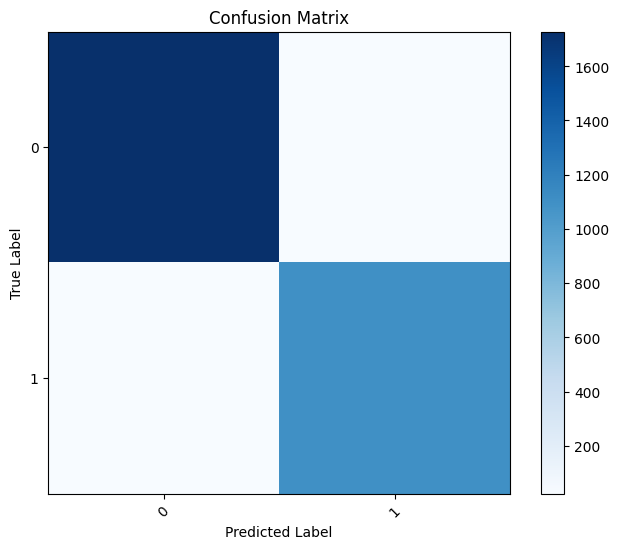

In [72]:
true_labels = []
predicted_labels = []

# Iterate through the test dataset and make predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.2f}")

# Generate a classification report with precision, recall, and F1-score
class_names = test_dataset.classes
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()